# Numeric Simulation 
## Solution with Relexation Method

In [1]:
import numpy as np

In [2]:
N=201 # an odd numbers give symetry with a point in the middle
H=N // 2 # this is the index of the middle point


We send in a current of -2 A in the middle and draw out exactly the same current over all border points. since there are 4 sides we divide by 4 and each side has N-1 points (the corner alredy belongs to the next side).
With a current of 2 A we get out the values for the resistance instead of the values of the potential in the 1 Ohm Grid.
Of course this only simulates the infinite grid very imprecisely because in the real infinite grid the values on the border are not the same on this square. (But their sum will be exactly the current injected in the middle). But since our grid is big we hope that the imperfect boundary conditions will not matter much for the points close to the origin.

In [3]:
I=np.zeros((N,N))
I[H,H]=-2
ir=2.0/4/(N-1)
I[0,:]=ir
I[-1,:]=ir
I[:,0]=ir
I[:,-1]=ir

The fourshift function takes the input array and builds a new array that adds up the array but shifted once alonge each axis. 
So this it the equivalent of $F_{n-1,m}+F_{n+1,m}+F_{n,m-1}+F_{n,m+1}$

Note that at the borders we do not add or you could say we add zero.


In [4]:
def fourshift(rin):
    rout=np.zeros(np.shape(rin))
    rout[1:,:] += rin[:-1,:]
    rout[:-1,:] += rin[1:,:]
    rout[:,1:] += rin[:,:-1]
    rout[:,:-1] += rin[:,1:]
    return rout
    

If we apply the above fourshift function to an array of all ones we get 4 on each point in the middle and 3 on the borders and 2 in the corners: zz is that array and rz is the array that holds the reciprocal values e.g. $$ \frac{1}{3} $$ at the border and $$ \frac{1}{4} $$ in the middle.

In [5]:
z=np.ones((N,N))

In [6]:
zz=fourshift(z)
rz=1/zz

This is the L operation: each step does a fourshift and then adds the current from the current array
and then calculates a new "output" value that is the division with the reciprocal
value from above. e.g. in the middle points without current the new middle values
is the sum of the 4 neighboring nodes divided by 4. On the boundary we only divide by
3 and in the corners only by 2. 

In [7]:
def L(rin):
    #print(np.shape(rin))
    ro=fourshift(rin)
    ro = (ro+I)  *rz
    ro -= ro[H,H]
    return ro
    
    

This loop applies the operation many times and thus creates more and more accurate values. The output value is only used "95%" to avoid overshooting. (with a value of more the 1 the system would already be unstable).

This iterative method of solving a system of linear equations is  called "Relaxation Method" 
[Relexation Method (Wikipedia)](https://en.wikipedia.org/wiki/Relaxation_(iterative_method))


In [8]:

r1=np.zeros((N,N))
for i in range(50000):
    rn=L(r1)
    r1 += (rn-r1)*0.95


In [9]:
r1[H+1,H+1]*0.5*np.pi

0.9999999994386013

In [10]:
r1[H,H+1]

0.4999999993718404

To see how quickly it converges we calculate the sum of errors found in each step.
This quickly goes down within the first few hundres itterations and reachess
 the limit of precission at a bit over 100k itterations. The remaining error
    of course is due to the fact that our grid is not infinite..

In [13]:
err=[]
r1=np.zeros((N,N))
for i in range(50000):
    rn=L(r1)
    err1=(rn-r1)*(rn-r1)
    errsum=np.sqrt(np.sum(err1,axis=(0,1))/N/N)
    err.append(errsum)
    r1 += (rn-r1)*0.95


In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

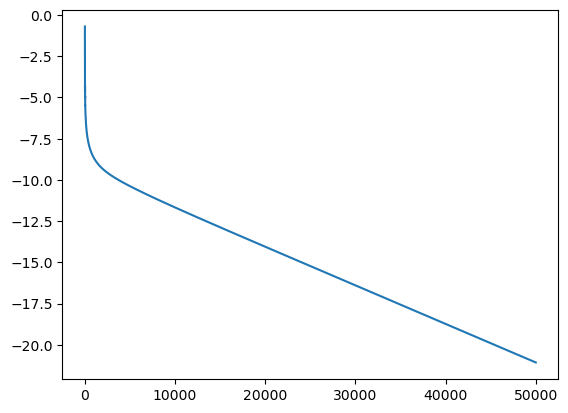

In [15]:
plt.plot(np.log(err))

In [16]:
r1[H+1,H+1]*0.5*np.pi


0.9999999994386013

An other option would be to only calculate in one quadrant. The shift looks similar to the one above. Except the middle of the grid is now at 0,0 and the row and columne at 0 gets the row or colume at 1 added twice (because of symetriy the colum at 1 is the same as the colume at -1). This time we get 4 times the number of grid points with the same amount of calculations:

In [19]:
N=200
def fourshiftq(rin):
    rout=np.zeros(np.shape(rin))
    rout[1:,:] += rin[:-1,:]
    rout[:-1,:] += rin[1:,:]
    rout[:,1:] += rin[:,:-1]
    rout[:,:-1] += rin[:,1:]
    rout[0,:] += rin[1,:]
    rout[:,0] += rin[:,1]
    return rout

For finding out who many shifts are added at each place we can use the same trick. This way we get a 4 at the origin (0,0) (the q at the end of the variable name now stands for "quater"

In [20]:
zq=np.ones((N,N))
zzq=fourshiftq(zq)
rzq=1/zzq


As we only look at 1/2 of the grid line on each of the 4 corners we have to divide the total
current by 8 now:

In [21]:
Iq=np.zeros((N,N))
Iq[0,0]=-2
irq=2.0/(8*(N-1))
Iq[-1,:]=irq
Iq[:,-1]=irq

In [23]:
def Lq(rin):
    ro=fourshiftq(rin)
    ro = (ro+Iq)  *rzq
    ro -= ro[0,0]
    return ro

In [24]:
err=[]
r1=np.zeros((N,N))
for i in range(50000):
    rn=Lq(r1)
    err1=(rn-r1)*(rn-r1)
    errsum=np.sqrt(np.sum(err1,axis=(0,1))/N/N)
    err.append(errsum)
    r1 += (rn-r1)*0.95
err[-10:]    

[1.1323622068152127e-06,
 1.1322934380493995e-06,
 1.1322246740209536e-06,
 1.1321559139412666e-06,
 1.132087158223649e-06,
 1.1320184068422637e-06,
 1.1319496594366876e-06,
 1.131880916744534e-06,
 1.1318121781703165e-06,
 1.1317434437908535e-06]

In [25]:
r1[1,1]*np.pi*0.5

0.9999967964093907

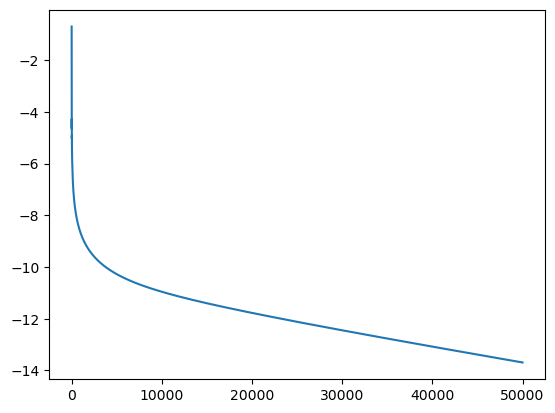

In [26]:
plt.plot(np.log(err))

We see that the precision actually decreased. Because with the same matrix size the grid is bigger it needs about 4 times the amount of iterations to get to the same precission.

In [27]:
err=[]
r1=np.zeros((N,N))
for i in range(250000):
    rn=Lq(r1)
    err1=(rn-r1)*(rn-r1)
    errsum=np.sqrt(np.sum(err1,axis=(0,1))/N/N)
    err.append(errsum)
    r1 += (rn-r1)*0.95
err[-10:]    

[8.077251363567758e-12,
 8.076755948670193e-12,
 8.076270452631651e-12,
 8.075761991157177e-12,
 8.075295576926286e-12,
 8.074791617613588e-12,
 8.074303034124184e-12,
 8.073805886329324e-12,
 8.073317810781156e-12,
 8.072820187228597e-12]

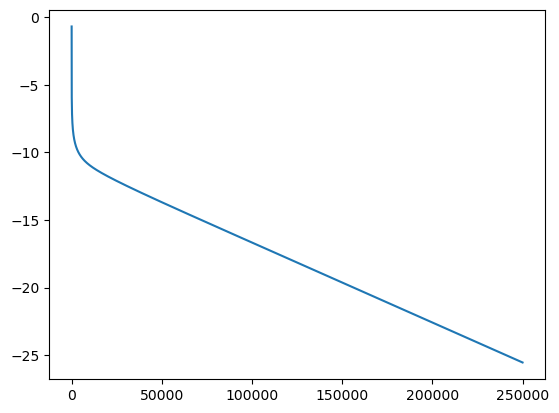

In [28]:
plt.plot(np.log(err))

In [29]:
r1[1,1]*np.pi*0.5

1.000000000069376

## Solution with Sparse Matrix Solution

Next we will go a different route: Instead of the "Relaxation Approach" above we want to use actual linear algebra to find a solution. If we inteprete the gird as a vector (e.g. if we have a quadrant with 200x200 points we could interprete this as a 40000 element vector). Then the application of our discrete Laplace operator could be written as a matrix multiplication. This would be a 40000x40000 element matrix with the 40000 element vectors as input and the resulting current distribution as output.

Solving the problem would then be an inversion of the matrix and multiplikation with the current vector to get the vector of potentials.
Now with even medium size distances (like 200 resistors from the origin) this will get huge matrices. Fortunately allmost all the elements in the matrix are zeros. (e.g. only 5 elements in each colum of 40000 elements are non-zero - describing the interaction of each grid points with the neighbouring grid points). 

Fortunately in scipy (an extension of numpy for scientific computing) there are routines that can handle such sparse matrices efficentely. Depending on what we want to do with them there are different implementation and you can also convert them in between and also to an from regular numpy arrays)

The main dificulty is to create the system of equations. For this we first create a mapping function that maps the coordindates on the grid (i and j) to an index in the vector. 

In [11]:
from scipy.sparse import dok_matrix,lil_matrix,linalg,csr_matrix,csc_matrix


In [12]:
N=200

# the mkidx function computes an index on our vector given the
# 2 coordindates on the grid:#

def mkidx(i,j):
    global N
    return i*N+j

# this function does the inverse of the above
def getidx(n):
    global N
    return (n//N,n%N)


In [14]:
# this function creates a sparse matrix that represents our
# laplace operator
# that is it sums up the 4 neighbouring elements and then subtracts
# 4 times the middle element.
# except at the border where ther are only 3 neighbors and 
# in the corner where there are only 2 neighbors.
# also in the middle line there is the special case that we
# mirror the line at the negative *,-1 or -1,* values as they
# are the same as the *,1 columsn or 1,* rows:
# this could be done way more efficient with
# clever slicing but that would not contribute to readability
#
def La():
    global N
    N2=N*N
    sa=dok_matrix((N2, N2))
    for i in range(N-1):
        for j in range(N):
            sa[mkidx(i+1,j),mkidx(i,j)  ] += 1
            sa[mkidx(i,j),  mkidx(i+1,j)] +=1
    for i in range(N):
        for j in range(N-1):
            sa[mkidx(i,j+1),mkidx(i,j)  ] +=1
            sa[mkidx(i,j),  mkidx(i,j+1)] +=1
    for j in range(N):
        sa[mkidx(0,j), mkidx(1,j)] += 1 
        sa[mkidx(j,0), mkidx(j,1)] += 1 
    for i in range(N):
        for j in range(N):
            zzz=4 if i < N-1 and j < N-1 else 3 if i < N-1 or j < N-1 else 2
            sa[mkidx(i,j), mkidx(i,j)] -= zzz
    sa[N2-1, N2-1] += 0.01  # see comment below     
    return sa


This will be our input current: We insert 2A at the origin (0,0) and an opposit current on all 4 corners of the square of our grid. Since we only see half of each grid side in each quadrant we have to divide by 8:


In [15]:
Is=np.zeros((N*N,))
Is[mkidx(0,0)]=2.0
irq=-2.0/(8*(N-1))
for i in range(N):
    Is[mkidx(i,N-1)]=irq
    Is[mkidx(N-1,i)]=irq  


the linalg.spsolve from the scipy package can solve the equation
$$ A*x=b $$ without fully inverting the matrix. Inverting would turn the sparse matrix into a full matrix in a lot of cases. So this would be undesirabel. Actually the spsolve is rather quick and accurate. Before we can use it we must convert the matrix into a different sparse format (csc_matrix here):

After that we add subtract potential at the origin from all values. 

In [16]:
s=La()
x=linalg.spsolve(csc_matrix(s),Is)
#print(x[0])
x -= x[0]
x

array([0.        , 0.5       , 0.72676046, ..., 2.35777961, 2.35865606,
       2.3592842 ])

In [17]:
x[mkidx(1,1)]*np.pi*0.5-1

9.208234175162033e-11

So this works quite well. Of course, since our matrix will always be finite we will always have an error here but even a 200x200 quater grid gives us already some 10 digits of accuracy. With this approach we can even calculate larger grids. E.g. a 1000x1000 quater grid takes about 5 minutes on a modern laptop (where most time is waisted in our inefficient loops for settung up the matrix).

**Update**

sa[N2-1, N2-1] += 0.01  

on the outer corner the value of sa would be 2 as there are 2 neighbors.  We introduce this error?

The matrix A is actually singular. That is its determinant would be zero. The solution is still solvedble but we have one unkown: a global offset to the potential.

But this produces warning messages in the sa solve. This small error alows to solve for the potential. We then subtract the potential in the middle anyways.

E.g. Think of the simpelest case: One resistor beteween 2 nodes. We send in the same current on the one side that we take out on the othger side. We get 2 equations for the potential but they both state the same fact. The potential on the one side is higher by the current and the potential on the other side lower by the current..

